In [15]:
import pandas as pd
df = pd.read_parquet("Combined_Flights_2018.parquet")

In [16]:
df_cleaned = df.dropna()
del(df)

In [24]:
missing_iata = ["PSE", "SJU", "STT", "STX", "PPG", "GUM", "SPN", "ROP"]

these 8 are not in continental US, noaa does not have these in its databse (it might, but i cleaned more than i wanted to) won't go back now

In [25]:
df_cleaned = df_cleaned[~df_cleaned["Origin"].isin(missing_iata)]
df_cleaned = df_cleaned[~df_cleaned["Dest"].isin(missing_iata)]

In [27]:
X = df_cleaned[["FlightDate", "Origin", "Dest", "CRSDepTime", "CRSArrTime", "Distance", "Month", "DayofMonth", "DayOfWeek", "IATA_Code_Marketing_Airline", "Tail_Number"]]
y_cancel = df_cleaned['Cancelled']
y_delay = df_cleaned['DepDelay']
y_arr = df_cleaned['ArrDelay']
del(df_cleaned)

In [28]:
y_cancel = y_cancel.astype(int)

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5531151 entries, 0 to 5578617
Data columns (total 11 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   FlightDate                   datetime64[us]
 1   Origin                       object        
 2   Dest                         object        
 3   CRSDepTime                   int64         
 4   CRSArrTime                   int64         
 5   Distance                     float64       
 6   Month                        int64         
 7   DayofMonth                   int64         
 8   DayOfWeek                    int64         
 9   IATA_Code_Marketing_Airline  object        
 10  Tail_Number                  object        
dtypes: datetime64[us](1), float64(1), int64(5), object(4)
memory usage: 506.4+ MB


In [30]:
X.isna().sum()

,0
FlightDate,0
Origin,0
Dest,0
CRSDepTime,0
CRSArrTime,0
Distance,0
Month,0
DayofMonth,0
DayOfWeek,0
IATA_Code_Marketing_Airline,0


In [31]:
aby = pd.read_csv("ABY.csv")

In [32]:
aby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12159 entries, 0 to 12158
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    12159 non-null  object 
 1   WND     12158 non-null  float64
 2   CIG     12159 non-null  float64
 3   VIS     12159 non-null  float64
 4   TMP     12159 non-null  float64
 5   DEW     12157 non-null  float64
 6   SLP     12129 non-null  float64
 7   AA1     12058 non-null  float64
 8   AA2     689 non-null    float64
 9   AT1     7675 non-null   float64
 10  AT2     5930 non-null   float64
 11  AU1     2432 non-null   float64
 12  AU2     829 non-null    float64
 13  AW1     2416 non-null   float64
 14  AW2     900 non-null    float64
 15  GD1     11971 non-null  float64
 16  GD2     3439 non-null   float64
 17  OC1     730 non-null    float64
dtypes: float64(17), object(1)
memory usage: 1.7+ MB


In [35]:
check = X.head().copy()

In [ ]:
import numpy as np

In [39]:
def parse_hhmm(t):
    """Convert time in HHMM format to hours, minutes tuple. Handles NaN gracefully."""
    if pd.isna(t):
        return np.nan, np.nan
    t = int(t)
    hour = t // 100
    minute = t % 100
    return hour, minute

# --- Create Departure datetime ---
dep_hm = X["CRSDepTime"].apply(parse_hhmm)
X["Dep_Hour"] = dep_hm.apply(lambda t: t[0])
X["Dep_Minute"] = dep_hm.apply(lambda t: t[1])

X["Dep_DateTime"] = pd.to_datetime(X["FlightDate"]) + pd.to_timedelta(
    X["Dep_Hour"].fillna(0).astype(int), unit="h"
) + pd.to_timedelta(
    X["Dep_Minute"].fillna(0).astype(int), unit="m"
)

# --- Create Arrival datetime ---
arr_hm = X["CRSArrTime"].apply(parse_hhmm)
X["Arr_Hour"] = arr_hm.apply(lambda t: t[0])
X["Arr_Minute"] = arr_hm.apply(lambda t: t[1])

X["Arr_DateTime"] = pd.to_datetime(X["FlightDate"]) + pd.to_timedelta(
    X["Arr_Hour"].fillna(0).astype(int), unit="h"
) + pd.to_timedelta(
    X["Arr_Minute"].fillna(0).astype(int), unit="m"
)

# --- Handle overnight arrivals (arrives next day) ---
# If scheduled arrival time is numerically *less* than departure time, it means next day arrival
mask_next_day = X["CRSArrTime"] < X["CRSDepTime"]
X.loc[mask_next_day, "Arr_DateTime"] += pd.Timedelta(days=1)

# Optional cleanup (remove helper cols if you want)
X.drop(columns=["Dep_Hour", "Dep_Minute", "Arr_Hour", "Arr_Minute"], inplace=True)

In [37]:
print("notebook abhi zinda hai")

notebook abhi zinda hai


In [41]:
X.to_parquet("2018_flights_cleaned_final_before_merging.parquet")

In [40]:
X.head()

,FlightDate,Origin,Dest,CRSDepTime,CRSArrTime,Distance,Month,DayofMonth,DayOfWeek,IATA_Code_Marketing_Airline,Tail_Number,Dep_DateTime,Arr_DateTime
0,2018-01-23,ABY,ATL,1202,1304,145.0,1,23,2,DL,N8928A,2018-01-23 12:02:00,2018-01-23 13:04:00
1,2018-01-24,ABY,ATL,1202,1304,145.0,1,24,3,DL,N800AY,2018-01-24 12:02:00,2018-01-24 13:04:00
2,2018-01-25,ABY,ATL,1202,1304,145.0,1,25,4,DL,N8836A,2018-01-25 12:02:00,2018-01-25 13:04:00
3,2018-01-26,ABY,ATL,1202,1304,145.0,1,26,5,DL,N800AY,2018-01-26 12:02:00,2018-01-26 13:04:00
4,2018-01-27,ABY,ATL,1400,1500,145.0,1,27,6,DL,N8839E,2018-01-27 14:00:00,2018-01-27 15:00:00


In [43]:
from google.colab import files

# Specify the path to your file in the Colab environment
file_path = '2018_flights_cleaned_final_before_merging.parquet'

# Execute the download command
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit the encoder to the 'city' column and transform it
# The fit_transform() method learns the unique categories and then converts the column
X['Origin_encoded'] = le.fit_transform(X['Origin'])
X['Dest_encoded'] = le.fit_transform(X['Dest'])
X['IATA_Code_Marketing_Airline_encoded'] = le.fit_transform(X['IATA_Code_Marketing_Airline'])

X.drop(['Origin', 'Dest', 'IATA_Code_Marketing_Airline'], axis=1, inplace=True)

X.info()

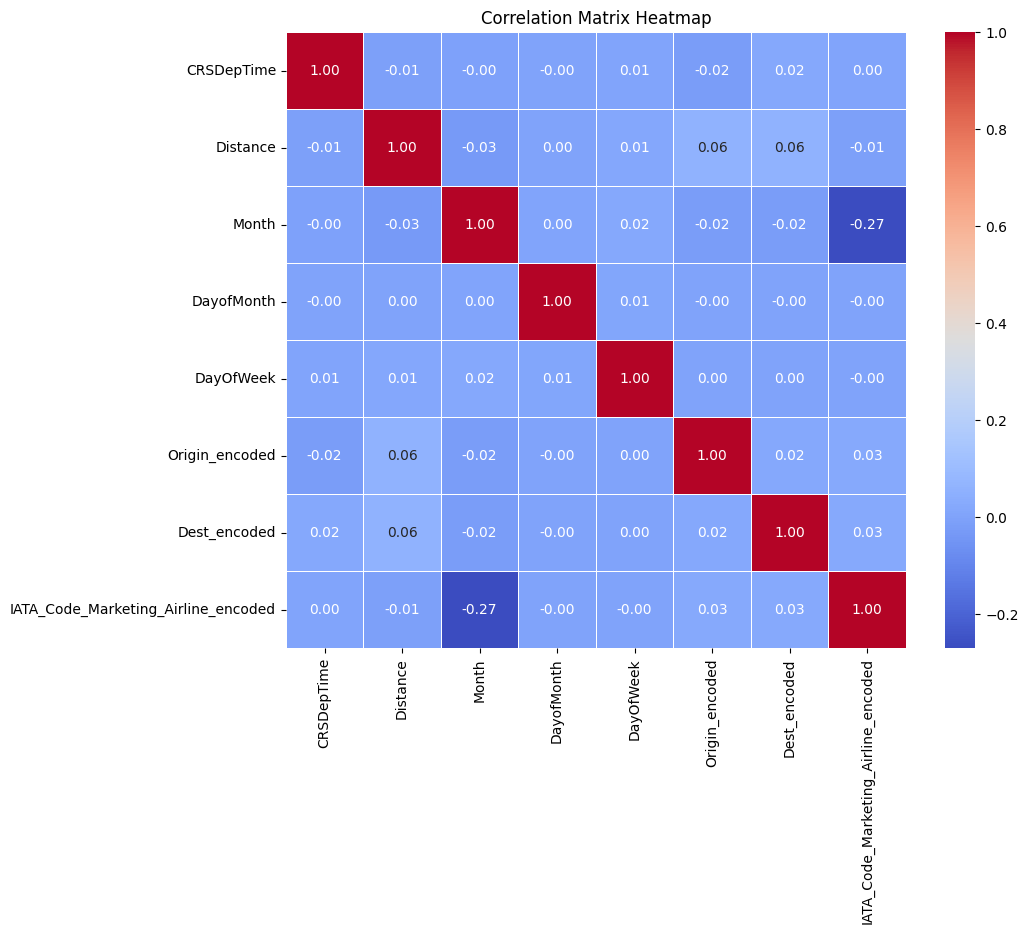

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X.corr()

# Create the heatmap
plt.figure(figsize=(10, 8)) # Optional: Adjust figure size for better clarity
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set the title of the plot
plt.title('Correlation Matrix Heatmap')

# Display the plot
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y_cancel, discrete_features='auto')
for col, score in zip(X.columns, mi):
    print(f"{col}: {score:.3f}")


CRSDepTime: 0.003
Distance: 0.002
Month: 0.126
DayofMonth: 0.042
DayOfWeek: 0.151
Origin_encoded: 0.021
Dest_encoded: 0.021
IATA_Code_Marketing_Airline_encoded: 0.154


In [ ]:
mi = mutual_info_classif(X, y_delay, discrete_features='auto')
for col, score in zip(X.columns, mi):
    print(f"{col}: {score:.3f}")

CRSDepTime: 0.038
Distance: 0.055
Month: 0.010
DayofMonth: 0.004
DayOfWeek: 0.008
Origin_encoded: 0.059
Dest_encoded: 0.041
IATA_Code_Marketing_Airline_encoded: 0.090


In [ ]:
with pd.option_context('display.max_rows', None):
    print(df.iloc[0])